# SMS Spam Classification – Notebook corregido
Este cuaderno soluciona los errores de forma y vacíos que provocaban fallos en el entrenamiento.

## 0. Descarga y limpieza del dataset

In [16]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

!wget -q -O spam.csv https://raw.githubusercontent.com/laxmimerit/SMS-Spam-Detection-using-LSTM-and-Attention/master/spam.csv

file_path = "spam.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} was not downloaded.")

df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1. Configuración y seed

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)

## 2. División Train/Test

In [18]:
y = df['label'].map({'ham':0,'spam':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")


4457 train | 1115 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [19]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))


## 4. Definición y entrenamiento del modelo

In [20]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8309 - loss: 0.4692 - val_accuracy: 0.8664 - val_loss: 0.3699
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8743 - loss: 0.3639 - val_accuracy: 0.8664 - val_loss: 0.3645
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8595 - loss: 0.3834 - val_accuracy: 0.8664 - val_loss: 0.3559
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8662 - loss: 0.3608 - val_accuracy: 0.8664 - val_loss: 0.3466
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8670 - loss: 0.3452 - val_accuracy: 0.8664 - val_loss: 0.3228


## 5. Curva de aprendizaje

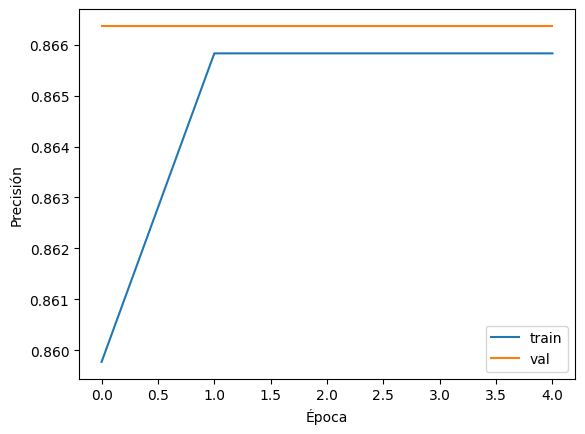

In [21]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()


## 6. Evaluación

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


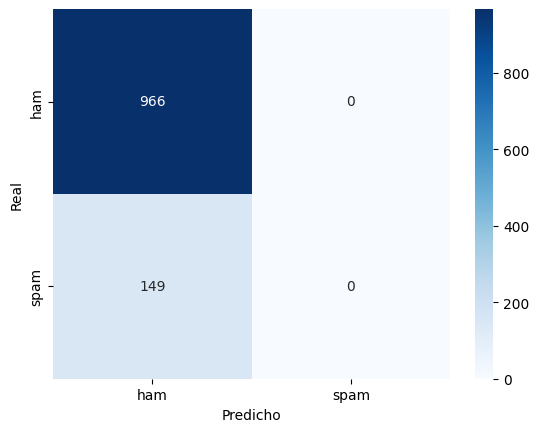

AUC: 0.9687773562882989


In [22]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))


## 7. Próximos pasos
- Aumentar `epochs` si no hay sobreajuste.
- Probar `class_weight={0:1,1:2}` en `model.fit`.
- Cambiar la arquitectura a `Bidirectional(LSTM(32))` para capturar contexto.
- Usar embeddings preentrenados (GloVe) para menos datos.

In [23]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8695 - loss: 0.3188 - val_accuracy: 0.8664 - val_loss: 0.2853
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8661 - loss: 0.2822 - val_accuracy: 0.9202 - val_loss: 0.2327
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9109 - loss: 0.2157 - val_accuracy: 0.9283 - val_loss: 0.1737
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9476 - loss: 0.1587 - val_accuracy: 0.9417 - val_loss: 0.1451
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9709 - loss: 0.1159 - val_accuracy: 0.9758 - val_loss: 0.0997
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9756 - loss: 0.0913 - val_accuracy: 0.9731 - val_loss: 0.0899
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9838 - loss: 0.0731 - val_accuracy: 0.9785 - val_loss: 0.0755
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9854 - loss: 0.0623 - val_accuracy

In [24]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10, class_weight={0: 1, 1: 2})

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9840 - loss: 0.0819 - val_accuracy: 0.9794 - val_loss: 0.0671
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9889 - loss: 0.0723 - val_accuracy: 0.9848 - val_loss: 0.0635
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9924 - loss: 0.0503 - val_accuracy: 0.9839 - val_loss: 0.0598
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9858 - loss: 0.0888 - val_accuracy: 0.9821 - val_loss: 0.0644
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9910 - loss: 0.0576 - val_accuracy: 0.9848 - val_loss: 0.0590
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9911 - loss: 0.0507 - val_accuracy: 0.9830 - val_loss: 0.0611
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9888 - loss: 0.0642 - val_accuracy: 0.9812 - val_loss: 0.0748
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9876 - loss: 0.0580 - val_accuracy: 

In [26]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    # Replacing GlobalAveragePooling1D with Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import zipfile

!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

GLOVE_FILE = 'glove.6B.100d.txt'

embeddings_index = {}
with open(GLOVE_FILE, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

vectorizer_vocab = vectorizer.get_vocabulary()
VOCAB_SIZE = len(vectorizer_vocab)

EMBEDDING_DIM = embeddings_index['a'].shape[0]

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for i, word in enumerate(vectorizer_vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector


model = tf.keras.Sequential([

    tf.keras.layers.Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        input_length=MAX_LEN,
        trainable=False,
    ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=10, class_weight={0: 1, 1: 2})
